In [1]:
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.stats import ranksums
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from bisect import bisect_left
from typing import List
import scipy.stats as ss
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from scipy import stats
from copy import deepcopy
seed = 0
np.random.seed(seed)
sig_num = 2

def VD_A(treatment: List[float], control: List[float]):
    """
    Computes Vargha and Delaney A index
    A. Vargha and H. D. Delaney.
    A critique and improvement of the CL common language
    effect size statistics of McGraw and Wong.
    Journal of Educational and Behavioral Statistics, 25(2):101-132, 2000
    The formula to compute A has been transformed to minimize accuracy errors
    See: http://mtorchiano.wordpress.com/2014/05/19/effect-size-of-r-precision/
    :param treatment: a numeric list
    :param control: another numeric list
    :returns the value estimate and the magnitude
    """
    m = len(treatment)
    n = len(control)

    if m != n:
        raise ValueError("Data d and f must have the same length")

    r = ss.rankdata(treatment + control)
    r1 = sum(r[0:m])

    # Compute the measure
    # A = (r1/m - (m+1)/2)/n # formula (14) in Vargha and Delaney, 2000
    A = (2 * r1 - m * (m + 1)) / (2 * n * m)  # equivalent formula to avoid accuracy errors

    levels = [0.147, 0.33, 0.474]  # effect sizes from Hess and Kromrey, 2004
    magnitude = ["negligible", "small", "medium", "large"]
    scaled_A = (A - 0.5) * 2

    magnitude = magnitude[bisect_left(levels, abs(scaled_A))]
    estimate = A

    return estimate, magnitude
def draw_hist(df_source, df_target, label, bin_num=40):
    bins=np.histogram(np.hstack((df_source[label],df_target[label])), bins=bin_num)[1]
    plt.hist(df_source[label], bins=bins, alpha = 0.5, label='source')
    plt.hist(df_target[label], bins=bins, alpha = 0.5, label='target')
    plt.title(label)
    plt.legend()
    print('Wilcoxon rank-sum test:', ranksums(df_source[label], df_target[label]))
    print('Vargha-Delaney effect size test', VD_A(df_source[label], df_target[label]))    

In [2]:
def stepwise_reg(df, x_labels, Y, pvalue_th):
    model = None
    while True:
        X = df[x_labels]
        model = sm.OLS(Y, X)
        results = model.fit()
        pvalues = results.pvalues
        p_max, p_max_ind = np.max(pvalues), np.argmax(pvalues)
        p_max_label = pvalues.index[p_max_ind]
        if p_max > pvalue_th:
            x_labels.remove(p_max_label)
        else:
            break
    return model, results

def tree_reg(X, Y, X_test, Y_test, model='CART'):
    print('-----'+model+'-----')
    if model == 'CART':
        clf = tree.DecisionTreeRegressor(random_state=seed)
    elif model == 'RF':
        clf = RandomForestRegressor(random_state=seed)
    else:
        raise
    
    clf = clf.fit(X, Y)
    test(clf, X_test, Y_test, '---source test---')
    
    return clf

def train_linear_transform(X, Y):
    reg = linear_model.LinearRegression()
    reg.fit(X, Y)
    return reg
    

def rank_shift(Y_pred, Y_test, X_test, top_ind, Y_source_test=[]):
    Y_ranks = np.round(stats.rankdata(Y_test)/len(Y_pred), sig_num)
    Y_pred_ranks = np.round(stats.rankdata(Y_pred)/len(Y_pred), sig_num)
    Y_source_ranks = np.round(stats.rankdata(Y_source_test)/len(Y_pred), sig_num)
    if len(Y_source_test) > 0:
        print('Target Values of Y_pred, Y_source, Y_target:', 
              Y_pred[top_ind], Y_source_test[top_ind], Y_test[top_ind])
        print('Ranks of Y_pred, Y_source, Y_target:', 
              Y_pred_ranks[top_ind], Y_source_ranks[top_ind], Y_ranks[top_ind])
    else:
        print('Target Values of Y_pred, Y_target:', 
              Y_pred[top_ind], Y_test[top_ind])
        print('Ranks of Y_pred, Y_target:', 
              Y_pred_ranks[top_ind], Y_ranks[top_ind])
    print('--Config of the top changed--')
    print(X_test.iloc[top_ind, :])
    print('----')

def test(clf, X_test, Y_test, title, Y_source_test=[], transform=None):
    Y_test = Y_test.to_numpy()
    Y_pred = clf.predict(X_test)
    if transform:
        Y_pred = np.expand_dims(Y_pred, axis=1)
        Y_pred = transform(Y_pred)
    print(title)
    
    print('spearmanr:', stats.spearmanr(Y_test, Y_pred))
    print('mean absolute percentage error:', np.mean(np.abs((Y_pred-Y_test)/Y_test)))
    
    if len(Y_source_test) > 0:
        #print('spearmanr(GT):', stats.spearmanr(Y_test, Y_source_test))
        
        Y_source_test = Y_source_test.to_numpy()
        
        Y_ranks = np.round(stats.rankdata(Y_test)/len(Y_pred), sig_num)
        Y_pred_ranks = np.round(stats.rankdata(Y_pred)/len(Y_pred), sig_num)
        Y_source_ranks = np.round(stats.rankdata(Y_source_test)/len(Y_pred), sig_num)
        Y_ranks_diff = np.round(Y_source_ranks-Y_ranks, sig_num)
        Y_ranks_diff_list = [(ind, Y_ranks_diff[ind], Y_source_ranks[ind], Y_ranks[ind], 
                              Y_pred_ranks[ind]) for ind in np.argsort(-np.abs(Y_ranks_diff))]
        #print('Top rank changes(index, rank change, src, tar, pred):', Y_ranks_diff_list[:30])
        Y_ranks_diff_list_top_perf = [quad for quad in Y_ranks_diff_list[:50] if quad[2] < 0.1 or quad[3] < 0.15]
        #print('rank changes w/ high performance in one domain(index, rank change, src, tar, pred):', Y_ranks_diff_list_top_perf)
        top_ind = Y_ranks_diff_list_top_perf[0][0]

        #rank_shift(Y_pred, Y_test, X_test, top_ind, Y_source_test)

def load_data(data_csv_source, data_csv_target):
    df_source = pd.read_csv(data_csv_source)
    df_target = pd.read_csv(data_csv_target)
    df_min_len = min([len(df_source), len(df_target)])
    df_min_len = min([df_min_len, 1000])
    df_source = df_source[:df_min_len]
    df_target = df_target[:df_min_len]
    return df_source, df_target

def plot_feature_importance(X_train, Y_train, X_test, Y_test, model, labels):
    clf = tree_reg(X_train, Y_train, X_test, Y_test, model=model)
    print(clf.feature_importances_)

    importances = clf.feature_importances_
    indices = np.argsort(importances)
    ax = plt.gca()
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(7)
    
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [labels[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()
    
    return clf, indices

def ebm(X_train, Y_train, X_test, Y_test):
    from interpret.glassbox import ExplainableBoostingRegressor, LinearRegression, RegressionTree
    lr = LinearRegression(random_state=seed)
    lr.fit(X_train, Y_train)

    rt = RegressionTree(random_state=seed)
    rt.fit(X_train, Y_train)

    ebm = ExplainableBoostingRegressor(random_state=seed)
    ebm.fit(X_train, Y_train)  

    from interpret import show
    from interpret.perf import RegressionPerf

    ebm_perf = RegressionPerf(ebm.predict).explain_perf(X_test, Y_test, name='EBM')
    lr_perf = RegressionPerf(lr.predict).explain_perf(X_test, Y_test, name='Linear Regression')
    rt_perf = RegressionPerf(rt.predict).explain_perf(X_test, Y_test, name='Regression Tree')
#     show(ebm_perf)
#     show(lr_perf)
#     show(rt_perf)
    
    ebm_global = ebm.explain_global(name='EBM')
    lr_global = lr.explain_global(name='LR')
    rt_global = rt.explain_global(name='RT')
    
    return ebm_global, lr_global, rt_global


def add_interaction(labels, df):
    labels_2 = deepcopy(labels)
    df_2 = df.copy()
    for l1 in labels:
        for l2 in labels:
            new_l = l1+':'+l2
            df_2[new_l] = df[l1]*df[l2]
            labels_2.append(new_l)
    return labels_2, df_2

## Load Data

In [32]:
data_csv_source = '../data/xavier_image_source.csv'
data_csv_target = '../data/xavier_image_target_cbench_sort.csv'
# data_csv_target = '../data/tx2_5000_image_target.csv'
# data_csv_target = '../data/tx1_5000_image_target.csv'
# data_csv_target = '../data/xavier_nlp_target.csv'

data_csv_source = '../data/tx2_5000_image_target.csv'
data_csv_target = '../data/tx2_20000_image_target_updated.csv'
#data_csv_target = '../data/tx2_20000_image_target.csv'

df_source, df_target = load_data(data_csv_source, data_csv_target)

y1_label = 'inference_time'
y2_label = 'total_energy_consumption'
y2_label = 'inference_time'

event_labels = [ "L1-dcache-load-misses", "L1-dcache-loads", "L1-dcache-stores", "branch-load-misses", "branch-loads",
  "branch-misses", "cache-misses", "cache-references", "context-switches",
   "cycles", "instructions", "irq_handler_entry", "irq_handler_exit",
   "softirq_entry", "softirq_exit", "softirq_raise", "major-faults",
   "migrations", "sys_enter", "sys_exit", "sched_boost_cpu",
  "sched_boost_task", "sched_migrate_task",
   "sched_process_exec", "sched_process_exit", "sched_process_fork", "sched_process_free",
   "sched_process_wait", "sched_stat_runtime", "sched_wakeup", "sched_wakeup_new",
   "sched_waking"]

config_labels = ["num_cores", "core_freq", "gpu_freq", "emc_freq",
               "cache_pressure", "swappiness", "dirty_ratio", "dirty_bg_ratio",
               "drop_caches", "policy", "sched_rt_runtime", "sched_child_runs_first",
               "memory_growth"]

# df_source[config_labels] = df_source[config_labels].apply(lambda x: (x-x.min())/ (x.max()-x.min()), axis=1)
# df_target[config_labels] = df_target[config_labels].apply(lambda x: (x-x.min())/ (x.max()-x.min()), axis=1)


# df_source_train, df_source_test = df_source.iloc[273:], df_source.iloc[:273]
# df_target_train, df_target_test = df_target.iloc[273:], df_target.iloc[:273]


df_source_train, df_source_test = train_test_split(df_source, test_size = 0.2, random_state=seed)
df_target_train, df_target_test = train_test_split(df_target, test_size = 0.2, random_state=seed)
print(len(df_source_train), len(df_source_test))
print(len(df_target_train), len(df_target_test))
# column_names = df_source.columns.values.tolist()
# print(column_names)

800 200
800 200


## CART and RF

In [33]:
x_labels = config_labels

X_train, Y_train = df_source_train[x_labels], df_source_train[y2_label]
X_test, Y_test = df_source_test[x_labels], df_source_test[y2_label]
clf = tree_reg(X_train, Y_train, X_test, Y_test, model='CART')

X_target_train, Y_target_train = df_target_train[x_labels], df_target_train[y2_label]
X_target_test, Y_target_test = df_target_test[x_labels], df_target_test[y2_label]

test(clf, X_target_test, Y_target_test, '---target test---', Y_test)

reg = train_linear_transform(np.expand_dims(Y_train.iloc[:5].to_numpy(), axis=1), Y_target_train.iloc[:5].to_numpy())

test(clf, X_target_test, Y_target_test, '---target test---', Y_test, transform=reg.predict)

-----CART-----
---source test---
spearmanr: SpearmanrResult(correlation=0.9476903464244927, pvalue=3.7863475571076966e-100)
mean absolute percentage error: 0.04806311647263223
---target test---
spearmanr: SpearmanrResult(correlation=0.13014639512186074, pvalue=0.06623477742891784)
mean absolute percentage error: 0.7767682192743622
---target test---
spearmanr: SpearmanrResult(correlation=0.13014639512186074, pvalue=0.06623477742891784)
mean absolute percentage error: 0.9861975000594267


In [34]:
x_labels = config_labels

X_train, Y_train = df_source_train[x_labels], df_source_train[y2_label]
X_test, Y_test = df_source_test[x_labels], df_source_test[y2_label]
clf = tree_reg(X_train, Y_train, X_test, Y_test, model='RF')

X_target_train, Y_target_train = df_target_train[x_labels], df_target_train[y2_label]
X_target_test, Y_target_test = df_target_test[x_labels], df_target_test[y2_label]

test(clf, X_target_test, Y_target_test, '---target test---', Y_test)

reg = train_linear_transform(np.expand_dims(Y_train.iloc[:5].to_numpy(), axis=1), Y_target_train.iloc[:5].to_numpy())

test(clf, X_target_test, Y_target_test, '---target test---', Y_test, transform=reg.predict)

-----RF-----
---source test---
spearmanr: SpearmanrResult(correlation=0.9192761528467247, pvalue=4.1021208830019007e-82)
mean absolute percentage error: 0.06105050816313965
---target test---
spearmanr: SpearmanrResult(correlation=0.07153314673157966, pvalue=0.31413634615620734)
mean absolute percentage error: 0.7710489655287662
---target test---
spearmanr: SpearmanrResult(correlation=0.07153314673157966, pvalue=0.31413634615620734)
mean absolute percentage error: 0.9947321311320105


## Causal Graph

### Source

In [279]:
# from causalnex.structure.notears import from_pandas
# struct_data = df_source_train.iloc[:500][config_labels+event_labels+[y1_label, y2_label]]
# sm_source = from_pandas(struct_data, h_tol=0.1, tabu_parent_nodes=[y1_label, y2_label], tabu_child_nodes=config_labels)

In [280]:
# sm_source.remove_edges_below_threshold(0.8)
# viz = plot_structure(
#     sm,
#     graph_attributes={"scale": "0.5"},
#     all_node_attributes=NODE_STYLE.WEAK,
#     all_edge_attributes=EDGE_STYLE.WEAK,
#     prog='fdp',
# )
# Image(viz.draw(format='png'))

### Target

In [281]:
# struct_data = df_target_train.iloc[:100][config_labels+event_labels+[y2_label]]
# sm_target = from_pandas(struct_data)

In [282]:
# sm_target.remove_edges_below_threshold(0.8)
# viz = plot_structure(
#     sm,
#     graph_attributes={"scale": "0.5"},
#     all_node_attributes=NODE_STYLE.WEAK,
#     all_edge_attributes=EDGE_STYLE.WEAK,
#     prog='fdp',
# )
# Image(viz.draw(format='png'))

## Feature Importance (SHAP)

### Train two CART (Options VS Objectives) and Gini Importance

-----CART-----
---source test---
spearmanr: SpearmanrResult(correlation=0.9476903464244927, pvalue=3.7863475571076966e-100)
mean absolute percentage error: 0.04806311647263223
[0.18580614 0.23743433 0.07674578 0.27524327 0.         0.04143377
 0.05138386 0.01843081 0.02258049 0.03694635 0.00961311 0.01995298
 0.02442911]


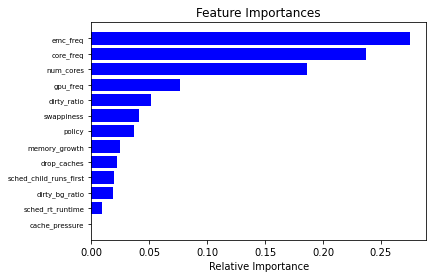

---target test---
spearmanr: SpearmanrResult(correlation=0.13014639512186074, pvalue=0.06623477742891784)
mean absolute percentage error: 0.7767682192743622
-----CART-----
---source test---
spearmanr: SpearmanrResult(correlation=0.11434121684233939, pvalue=0.10692164127910306)
mean absolute percentage error: 0.6122838442517972
[0.09160342 0.15018352 0.17105608 0.10774459 0.         0.0707084
 0.0956126  0.08595617 0.05045937 0.04029789 0.02376596 0.04395621
 0.0686558 ]


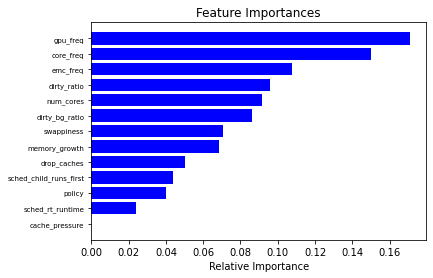

ranking spearmanr: SpearmanrResult(correlation=0.7637362637362637, pvalue=0.002376614797908445)


In [23]:
X_train, Y_train = df_source_train[config_labels], df_source_train[y2_label]
X_test, Y_test = df_source_test[config_labels], df_source_test[y2_label]

X_target_train, Y_target_train = df_target_train[config_labels], df_target_train[y2_label]
X_target_test, Y_target_test = df_target_test[config_labels], df_target_test[y2_label]


model = 'CART'
# source model
clf_source, inds_rank_source = plot_feature_importance(X_train, Y_train, X_test, Y_test, model, config_labels)

test(clf_source, X_target_test, Y_target_test, '---target test---', Y_test)

# target model
clf_target, inds_rank_target = plot_feature_importance(X_target_train, Y_target_train, X_target_test, Y_target_test, model, config_labels)

print('ranking spearmanr:', stats.spearmanr(inds_rank_source, inds_rank_target))

### Train two CART (Events VS Objectives) and Gini Importance

-----CART-----
---source test---
spearmanr: SpearmanrResult(correlation=0.9930295884709329, pvalue=7.771605350373405e-186)
mean absolute percentage error: 0.01888072200643165
[1.53868992e-03 6.80232991e-03 3.80924467e-05 1.97008397e-04
 1.19289543e-03 2.27536078e-01 2.24972588e-05 1.46920517e-04
 7.30432239e-02 4.94163580e-03 2.49269139e-05 6.42929539e-03
 1.39925917e-03 3.50583540e-03 3.82426094e-05 1.33654198e-05
 1.77791533e-04 1.50846809e-04 6.00851764e-02 1.42982390e-02
 0.00000000e+00 1.67156661e-05 1.30092735e-04 1.77933695e-02
 4.57313761e-01 1.54489790e-03 4.72762472e-03 1.09817169e-03
 4.17222368e-03 5.67945022e-06 1.10965967e-01 6.49146303e-04]


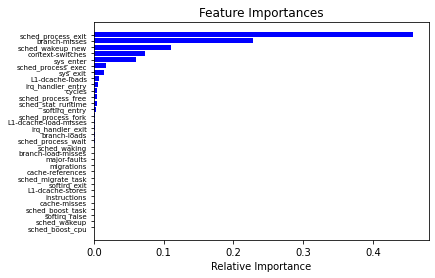

---target test---
spearmanr: SpearmanrResult(correlation=0.3148379247722561, pvalue=5.610032354560724e-06)
mean absolute percentage error: 0.37877954641458017
-----CART-----
---source test---
spearmanr: SpearmanrResult(correlation=0.17695228799572502, pvalue=0.01218951358988968)
mean absolute percentage error: 0.549979571932392
[0.01885887 0.04183595 0.02656547 0.00365931 0.05441465 0.03335733
 0.00485678 0.02579536 0.03778857 0.01753292 0.01015601 0.03271737
 0.02558161 0.03675669 0.04556411 0.02872424 0.0122246  0.01564374
 0.06430457 0.04070242 0.         0.02339738 0.02208438 0.05167301
 0.02826353 0.00427567 0.02047086 0.01715434 0.02745654 0.0357673
 0.00921079 0.18320561]


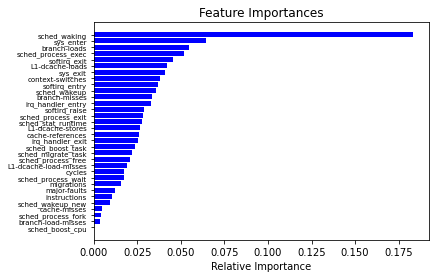

ranking spearmanr: SpearmanrResult(correlation=-0.2071114369501466, pvalue=0.2553829265748573)


In [24]:
X_train, Y_train = df_source_train[event_labels], df_source_train[y2_label]
X_test, Y_test = df_source_test[event_labels], df_source_test[y2_label]

X_target_train, Y_target_train = df_target_train[event_labels], df_target_train[y2_label]
X_target_test, Y_target_test = df_target_test[event_labels], df_target_test[y2_label]

# source model
clf_source, inds_rank_source = plot_feature_importance(X_train, Y_train, X_test, Y_test, 'CART', event_labels)

test(clf_source, X_target_test, Y_target_test, '---target test---', Y_test)

# target model
clf_target, inds_rank_target = plot_feature_importance(X_target_train, Y_target_train, X_target_test, Y_target_test, 'CART', event_labels)

print('ranking spearmanr:', stats.spearmanr(inds_rank_source, inds_rank_target))

### Train two CART (Options+Events VS Objectives) and Gini Importance

-----CART-----
---source test---
spearmanr: SpearmanrResult(correlation=0.9863013185183374, pvalue=6.261159177965813e-157)
mean absolute percentage error: 0.00990017611374495
[1.83811515e-05 5.08436647e-04 3.26042128e-04 6.77763777e-05
 1.12358387e-04 1.29053603e-04 2.33814484e-05 1.70949732e-04
 1.32172760e-05 2.57000081e-06 3.33411421e-07 8.29678076e-06
 5.15322259e-05 1.23728344e-04 4.06345631e-04 4.20264276e-05
 5.65745835e-05 2.32211235e-02 1.61285262e-04 3.15878492e-03
 1.51296286e-04 1.11881568e-03 9.92024916e-03 2.25913418e-03
 2.96536577e-05 7.75072466e-05 1.93354020e-04 3.13474377e-05
 7.82354899e-05 2.27874759e-05 3.38702685e-04 1.24348874e-03
 8.68430199e-01 2.91217926e-05 1.22640995e-04 2.62803005e-04
 1.47237060e-02 4.08809996e-06 2.94935680e-07 7.11732313e-02
 8.19374203e-04 1.55505612e-04 1.16137308e-04 5.65156222e-05
 3.96124333e-05]


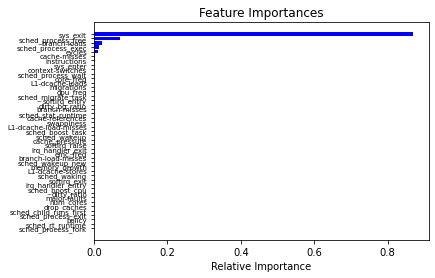

---target test---
spearmanr: SpearmanrResult(correlation=0.6147731633329877, pvalue=3.5466460521278532e-22)
mean absolute percentage error: 0.2631306807669867
-----CART-----
---source test---
spearmanr: SpearmanrResult(correlation=0.9082358765710263, pvalue=7.613659354480863e-77)
mean absolute percentage error: 0.10143816650837513
[7.95030757e-05 1.46305323e-03 1.64082754e-01 3.38330406e-02
 1.29481730e-05 2.17962961e-05 9.02544840e-05 8.38770900e-06
 4.95197190e-05 4.41110090e-07 7.22297371e-05 1.90228814e-05
 6.91688992e-05 9.29947887e-04 9.93101142e-04 6.25522600e-04
 1.29194085e-04 1.46222316e-03 1.34656580e-04 2.74303719e-04
 5.08681031e-04 5.42221884e-04 1.25570690e-03 4.98142408e-04
 7.15703636e-04 4.78177526e-02 8.99193045e-04 2.88732278e-04
 8.09611944e-04 1.62144775e-03 3.96487826e-04 2.52262132e-03
 1.65405740e-03 3.71317775e-04 2.58157087e-04 5.25623289e-04
 2.70828311e-03 8.64413364e-04 4.15124809e-03 1.07636870e-03
 1.20991380e-02 6.93436497e-01 5.12410783e-04 1.97861060e

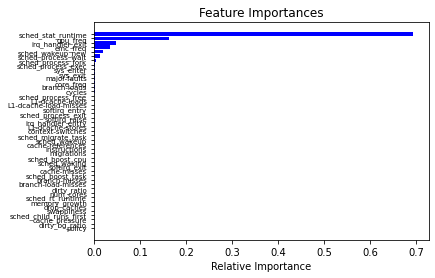

ranking spearmanr: SpearmanrResult(correlation=0.19512516469038205, pvalue=0.1989692832529377)


In [14]:
X_train, Y_train = df_source_train[config_labels+event_labels], df_source_train[y2_label]
X_test, Y_test = df_source_test[config_labels+event_labels], df_source_test[y2_label]

X_target_train, Y_target_train = df_target_train[config_labels+event_labels], df_target_train[y2_label]
X_target_test, Y_target_test = df_target_test[config_labels+event_labels], df_target_test[y2_label]

# source model
clf_source, inds_rank_source = plot_feature_importance(X_train, Y_train, X_test, Y_test, 'CART', config_labels+event_labels)

test(clf_source, X_target_test, Y_target_test, '---target test---', Y_test)

# target model
clf_target, inds_rank_target = plot_feature_importance(X_target_train, Y_target_train, X_target_test, Y_target_test, 'CART', config_labels+event_labels)

print('ranking spearmanr:', stats.spearmanr(inds_rank_source, inds_rank_target))

### XBM

In [267]:
X_train, Y_train = df_source_train[config_labels], df_source_train[y2_label]
X_test, Y_test = df_source_test[config_labels], df_source_test[y2_label]

X_target_train, Y_target_train = df_target_train[config_labels], df_target_train[y2_label]
X_target_test, Y_target_test = df_target_test[config_labels], df_target_test[y2_label]

In [268]:
ebm_global_source, lr_global_source, rt_global_source = ebm(X_train, Y_train, X_test, Y_test)

In [269]:
show(ebm_global_source)

<!-- http://127.0.0.1:7001/140606238969088/ -->

In [270]:
ebm_global_target, lr_global_target, rt_global_target = ebm(X_target_train, Y_target_train, X_target_test, Y_target_test)

In [271]:
show(ebm_global_target)

<!-- http://127.0.0.1:7001/140607784315872/ -->

In [260]:
names_s = ebm_global_source._internal_obj['overall']['names']
names_t = ebm_global_target._internal_obj['overall']['names']
print(len(names_s), len(names_t), len(np.intersect1d(names_s, names_t)))

23 23 20


### SHAP Source

In [41]:
import shap
shap.initjs()
rf_explainer = shap.KernelExplainer(clf_rf.predict, X_test)
rf_shap_values = rf_explainer.shap_values(X_test)


Using 288 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/288 [00:00<?, ?it/s]

In [44]:
# plot the SHAP values for the 10th observation 
shap.force_plot(rf_explainer.expected_value, rf_shap_values[10,:], X_test.iloc[10,:]) #, link="logit")

In [45]:
shap.force_plot(rf_explainer.expected_value, rf_shap_values, X_test)

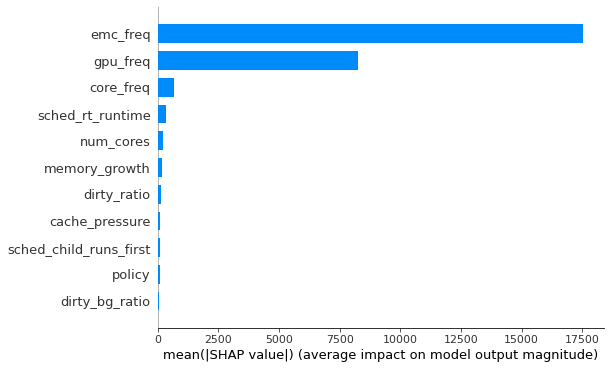

In [46]:
shap.summary_plot(rf_shap_values, X_test, plot_type="bar")

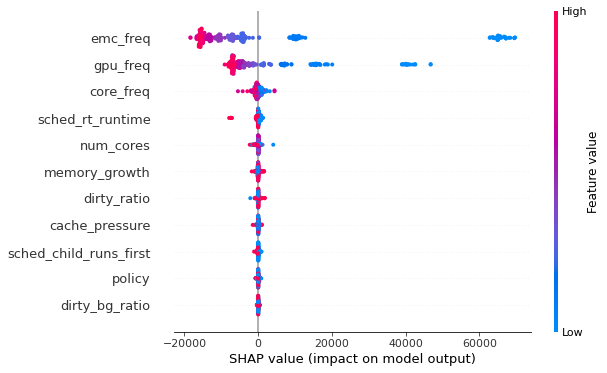

In [47]:
shap.summary_plot(rf_shap_values, X_test)

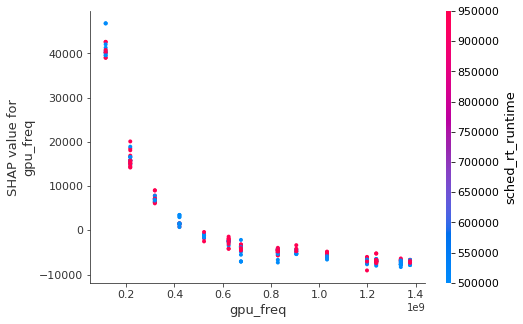

In [49]:
shap.dependence_plot("gpu_freq", rf_shap_values, X_test)

### SHAP Target

In [83]:
rf_explainer = shap.KernelExplainer(clf_rf_target.predict, X_target_test)
rf_shap_values = rf_explainer.shap_values(X_target_test)

Using 288 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/288 [00:00<?, ?it/s]

In [84]:
# plot the SHAP values for the 10th observation 
shap.force_plot(rf_explainer.expected_value, rf_shap_values[10,:], X_test.iloc[10,:]) #, link="logit")

In [85]:
shap.force_plot(rf_explainer.expected_value, rf_shap_values, X_test)

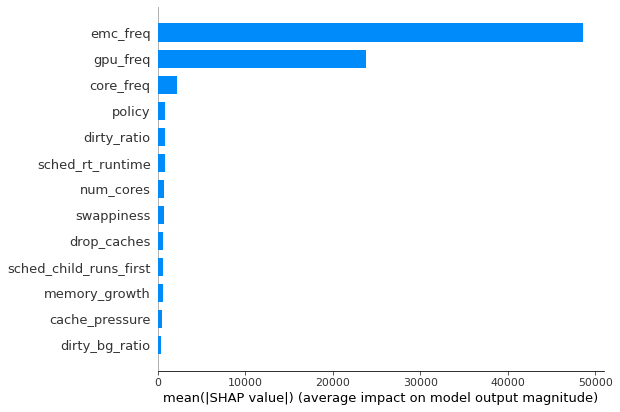

In [86]:
shap.summary_plot(rf_shap_values, X_test, plot_type="bar")

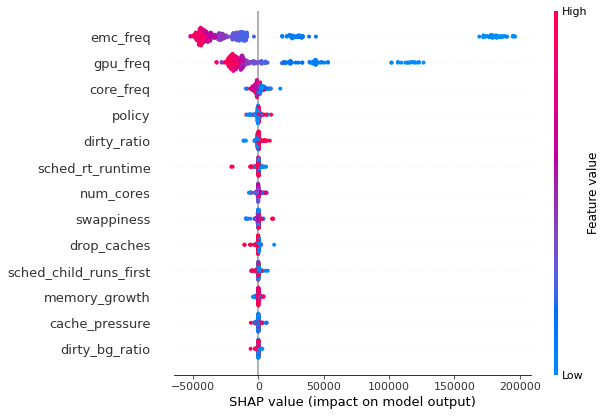

In [87]:
shap.summary_plot(rf_shap_values, X_test)

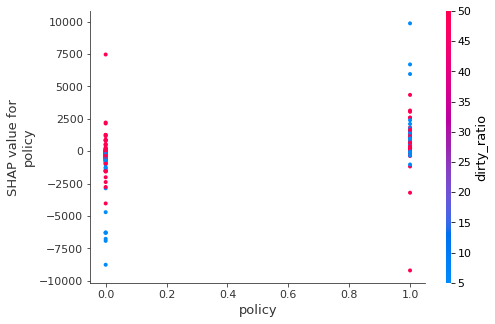

In [89]:
shap.dependence_plot("policy", rf_shap_values, X_test)

## Stepwise Regression (Options & Objectives)

### Add interaction terms to data

In [121]:


x_labels = config_labels
x_labels_2, df_source_2 = add_interaction(x_labels, df_source)
_, df_target_2 = add_interaction(x_labels, df_target)

df_source_2_norm = df_source_2.copy()
df_target_2_norm = df_target_2.copy()

df_source_2_norm[x_labels_2] = df_source_2[x_labels_2].apply(lambda x: (x-x.min())/ (x.max()-x.min()), axis=1)
df_target_2_norm[x_labels_2] = df_target_2[x_labels_2].apply(lambda x: (x-x.min())/ (x.max()-x.min()), axis=1)

# df_source_2_norm_train, df_source_2_norm_test = df_source_2_norm.iloc[273:], df_source_2_norm.iloc[:273]
# df_target_2_norm_train, df_target_2_norm_test = df_target_2_norm.iloc[273:], df_target_2_norm.iloc[:273]


df_source_2_norm_train, df_2_norm_source_test = train_test_split(df_source_2_norm, test_size = 0.2, random_state=seed)
df_target_2_norm_train, df_2_norm_target_test = train_test_split(df_target_2_norm, test_size = 0.2, random_state=seed)


In [125]:
Y = df_source_train[y2_label]

model_source, results_source = stepwise_reg(df_source_2_norm_train, x_labels_2, Y, 0.05)
print(results_source.params)
print(np.argsort(np.abs(results_source.params)))

core_freq                           -5.191489e+15
gpu_freq                             1.977782e+13
sched_rt_runtime                     2.674835e+16
num_cores:gpu_freq                  -3.206884e+12
num_cores:emc_freq                   2.830685e+12
core_freq:core_freq                  2.131266e+09
core_freq:sched_child_runs_first    -1.018247e+15
gpu_freq:gpu_freq                    9.820723e+04
gpu_freq:cache_pressure              1.062200e+10
gpu_freq:sched_child_runs_first      2.975572e+12
emc_freq:gpu_freq                   -1.641809e+05
emc_freq:emc_freq                    7.285275e+04
cache_pressure:cache_pressure       -2.034460e+16
cache_pressure:swappiness           -2.244488e+16
cache_pressure:sched_rt_runtime      4.534109e+12
swappiness:cache_pressure           -2.244488e+16
swappiness:sched_rt_runtime         -7.084247e+12
dirty_ratio:dirty_bg_ratio           2.284691e+16
dirty_bg_ratio:dirty_ratio           2.284691e+16
sched_rt_runtime:cache_pressure      4.534109e+12


In [126]:
Y = df_target_train[y2_label]
x_labels = config_labels
model_target, results_target = stepwise_reg(df_target_2_norm_train, x_labels_2, Y, 0.05)
print(results_target.params)
print(np.argsort(np.abs(results_target.params)))

core_freq                           -6.718077e+16
gpu_freq                            -3.533782e+14
sched_rt_runtime                     5.036355e+17
num_cores:gpu_freq                   3.060628e+13
num_cores:emc_freq                  -2.187627e+13
core_freq:core_freq                  2.182156e+10
core_freq:sched_child_runs_first     6.054996e+15
gpu_freq:gpu_freq                    5.240264e+05
gpu_freq:cache_pressure             -5.568737e+16
gpu_freq:sched_child_runs_first     -1.029178e+13
emc_freq:gpu_freq                   -4.526603e+05
emc_freq:emc_freq                    3.509411e+05
cache_pressure:cache_pressure       -5.568737e+16
cache_pressure:swappiness           -5.568737e+16
cache_pressure:sched_rt_runtime     -5.568737e+16
swappiness:cache_pressure           -5.568737e+16
swappiness:sched_rt_runtime         -5.644892e+13
dirty_ratio:dirty_bg_ratio          -5.698007e+16
dirty_bg_ratio:dirty_ratio          -5.698007e+16
sched_rt_runtime:cache_pressure     -5.568737e+16


In [124]:
inds = results_source.params.index.to_numpy()
indt = results_target.params.index.to_numpy()
print(len(inds), len(indt), len(np.intersect1d(inds, indt)))

56 38 38


## Stepwise Regression (System Events & Objectives)

## Target Values Distribution

Wilcoxon rank-sum test: RanksumsResult(statistic=-41.989611884618725, pvalue=0.0)
Vargha-Delaney effect size test (0.0, 'large')


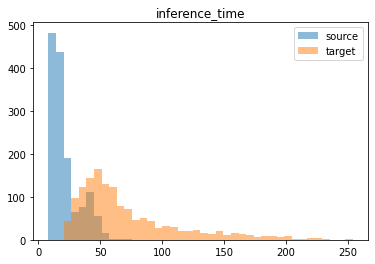

In [33]:
draw_hist(df_source, df_target, y1_label)

Wilcoxon rank-sum test: RanksumsResult(statistic=-39.53548988863196, pvalue=0.0)
Vargha-Delaney effect size test (0.0, 'large')


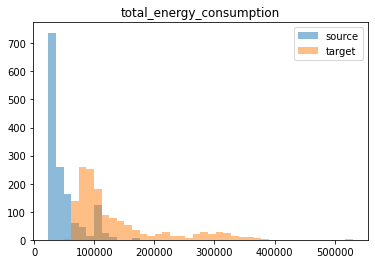

In [34]:
draw_hist(df_source, df_target, y2_label)

Wilcoxon rank-sum test: RanksumsResult(statistic=-45.169030304095706, pvalue=0.0)
Vargha-Delaney effect size test (0.0, 'large')


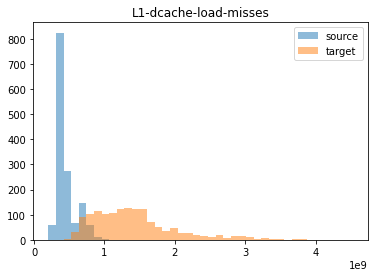

In [35]:
draw_hist(df_source, df_target, "L1-dcache-load-misses")

Wilcoxon rank-sum test: RanksumsResult(statistic=-45.15312443965656, pvalue=0.0)
Vargha-Delaney effect size test (0.0, 'large')


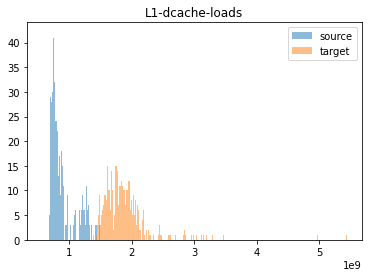

In [276]:
draw_hist(df_source, df_target, "L1-dcache-loads", 1000)